In [137]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

FONTSIZE =16
LABELSIZE =16

In [138]:
dataset_name = 'tkgl-gdelt'
windows = [3, 5, 10, 50, 100]
windows_plot = [3, 10, 50]
if 'gdelt' in dataset_name:
    windows = [3, 50, 100, 200]
    windows_plot = [3, 50, 100]
# windows_plot = [3, 10, 50]


rule_paths = []
for window in windows:

    rule_path = f'./../rules/{dataset_name}-learn-cyc1nonrec-cyc1rec-crules-multi-window{window}-0-0-ruleset-ids.txt'
    if 'gdelt' in dataset_name:
        rule_path = f'./../rules/{dataset_name}-learn-cyc1nonrec-cyc1rec-multi-window{window}-0-0-ruleset-ids.txt'
    rule_paths.append(rule_path)

In [139]:

def read_rules(path):
    """ read all rules stored in the file stored at path
    :param path: path to the file with rules

    """



    f = open(path, "r")
    params = []
    for line in f:
        values = line.split("\t")
        param = values[:-2]  
        for i in range(len(param)):
            param[i] = float(param[i])
        params.append(param)

    f.close()
    return params

def score_linear(x, rho, kappa, gamma):
    val = rho*x + kappa
    return np.clip(val, -gamma, gamma)


def score_powtwo(delta_t, lmbda, phi):
    """ calculate the score using the two to the power of lambda * deltat function from history repeats itself paper

    :param delta_t: float, the time difference between the query and most recent occurence
    :param lmbda: float, the lambda parameter i.e. time decay
    :param alpha: float, the alpha parameter, i.e. rule confidence scale
    :param phi: float, offset parameter, to shift the function up and down (but still stay between 0 and 1)   
    :return: float, the score for the given parameters
    """
    offset = phi
    return 1.0/(1.0+offset)*(pow(2, -lmbda * (delta_t-1)) + offset)

def score_single(distance, lmbda, alpha, phi):
    """ Calculate candidate score depending on the time differences of the observed triples.
    section 4. equation (12)
    :param distance The distance for which the score is computed
    :param params: (lmbda, alpha, phi)
    :param function_type (str): type of function to use for scoring. Options: 'powtwo', 'increasing_powtwo', 'cos'
    :return: score (float): score for each sample computed using the given function
    """
    return alpha*score_powtwo(distance,lmbda,phi)


In [140]:
path = rule_paths[0]
params_window_10 = read_rules(path)
df_list = []
for hp_name, rule_path in zip(windows, rule_paths):
    params = read_rules(rule_path)
    df = pd.DataFrame(params, columns=['lmbda', 'alpha', 'phi', "rho", "kappa", "gamma"])
    df["hyperparam"] = hp_name
    df_list.append(df)
# Combine into one DataFrame
df_all = pd.concat(df_list, ignore_index=True)

print(df_all.head())


          lmbda     alpha           phi       rho     kappa     gamma  \
0  9.404384e-01  0.099524  3.000000e+00  0.112434 -0.046161  0.160460   
1  4.484013e+01  0.031250  1.630573e+00 -0.024098  0.010013  0.031250   
2  1.124162e+00  0.035418  3.000000e+00  0.036002 -0.014809  0.047690   
3  1.000000e-10  0.021517  1.000000e-10  0.020394 -0.008543  0.017876   
4  6.100453e-01  0.030508  3.000000e+00  0.028003 -0.011516  0.038157   

   hyperparam  
0           3  
1           3  
2           3  
3           3  
4           3  


In [141]:
df_all['lmbda'].min()

0.0

C:\Users\jgasting\AppData\Local\Temp\ipykernel_38340\3911485201.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("viridis", N)


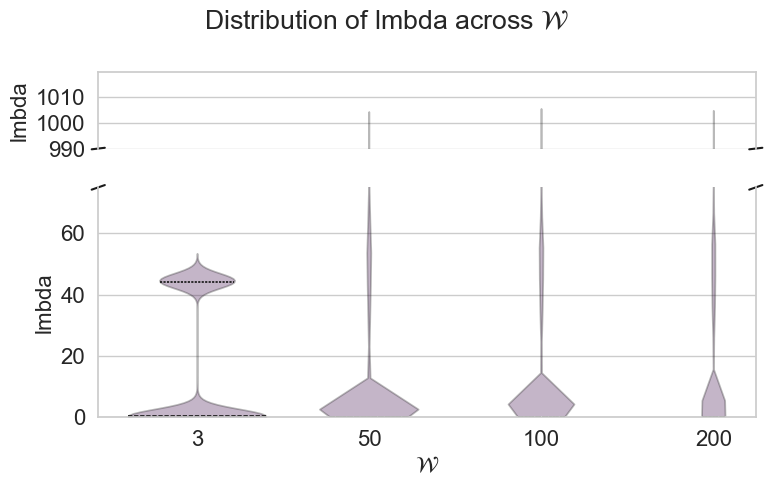

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
N=5
param = "lmbda"
colors = cm.get_cmap("viridis", N)
color_list = [colors(i) for i in range(N)]
color = color_list[0]   # number in [0, 1]
plt.rcParams.update({
    'font.size': FONTSIZE,          # default text size
    'axes.titlesize': FONTSIZE,     # title
    'axes.labelsize': LABELSIZE,     # x/y labels
    'xtick.labelsize': LABELSIZE,    # x-tick labels
    'ytick.labelsize': LABELSIZE,    # y-tick labels
    'legend.fontsize': LABELSIZE    # legend
})
# Choose your cut points
lower_max = 75
upper_min = 990
if dataset_name == 'tkgl-wikiold':
    lower_max = 100
    upper_min = 750

fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(8, 5), 
    sharex=True,
    gridspec_kw={'height_ratios': [1, 3]}
)
fig.subplots_adjust(hspace=0.05)

# Top axis (large values)
sns.violinplot(
    data=df_all,
    x="hyperparam",
    y=param,
    inner="quartile",
    ax=ax1,
    color =color,
    alpha=0.3
)
ax1.set_ylim(upper_min, df_all[param].max()+20)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labelbottom=False)

# Bottom axis (small values)
sns.violinplot(
    data=df_all,
    x="hyperparam",
    y=param,
    inner="quartile",
    ax=ax2,
    color =color,
    alpha=0.3
    
)
ax2.set_ylim(0, lower_max)
ax2.spines['top'].set_visible(False)

# Add diagonal break marks
d = .01  # how big the diagonal lines are
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)

ax1.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
ax2.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

plt.suptitle(f"Distribution of {param} across "+ "$\mathcal{W}$")
plt.xlabel("$\mathcal{W}$")
plt.ylabel(param)
plt.tight_layout()
plt.savefig(f"violin_plot_{param}_with_breaks_{dataset_name}.png")
plt.savefig(f"violin_plot_{param}_with_breaks_{dataset_name}.pdf")
plt.show()


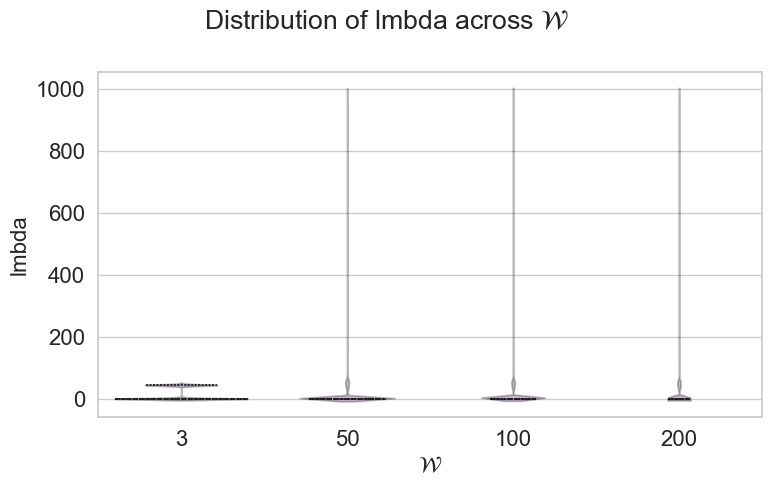

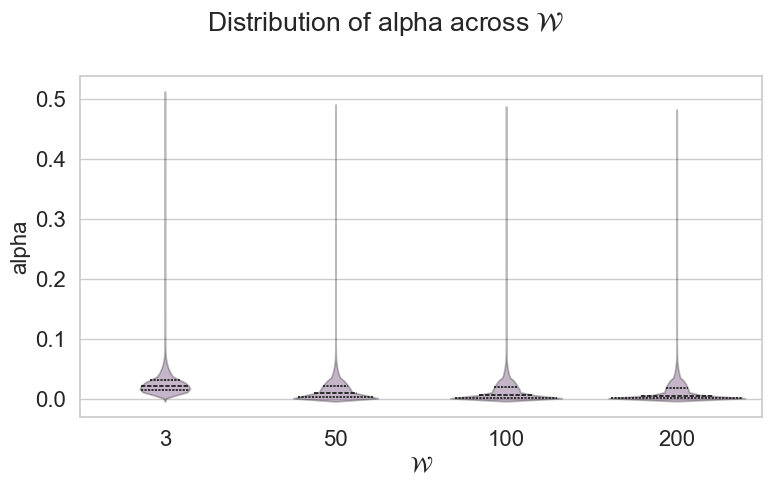

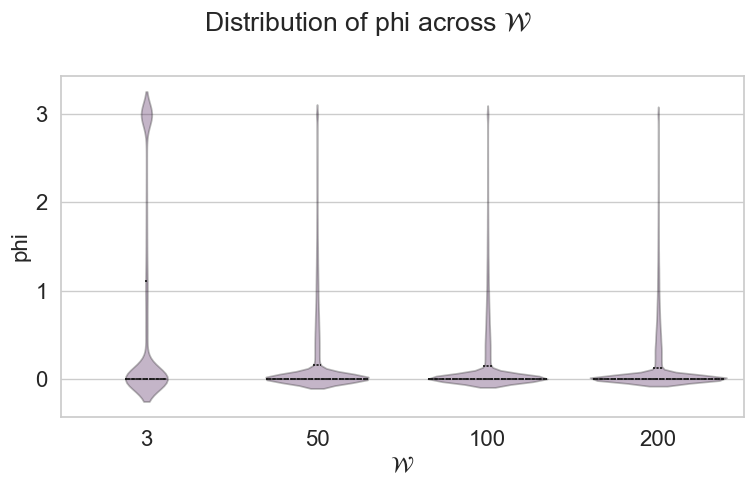

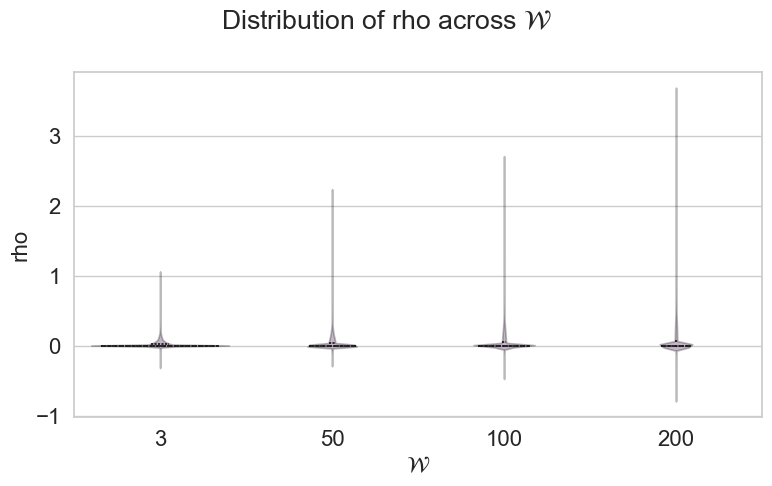

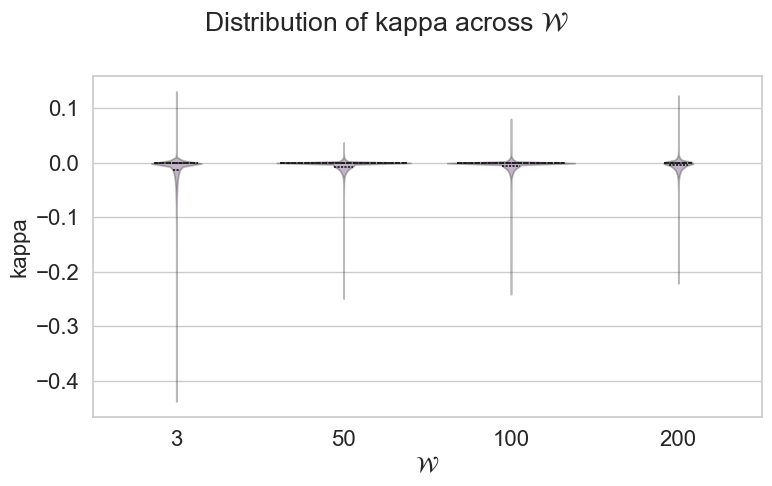

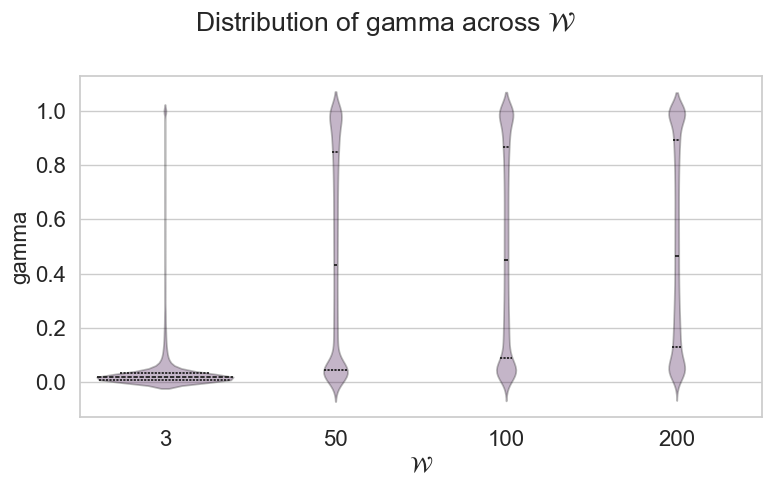

In [143]:

sns.set(style="whitegrid")
param_cols = ['lmbda', 'alpha', 'phi', "rho", "kappa", "gamma"]
for param in param_cols:
    plt.figure(figsize=(8, 5))
    plt.rcParams.update({
    'font.size': FONTSIZE,          # default text size
    'axes.titlesize': FONTSIZE,     # title
    'axes.labelsize': LABELSIZE,     # x/y labels
    'xtick.labelsize': LABELSIZE,    # x-tick labels
    'ytick.labelsize': LABELSIZE,    # y-tick labels
    'legend.fontsize': LABELSIZE    # legend
    })

    # df_sub = df_all.sample(2000)   # pick 2000 points max
    # sns.boxenplot(data=df_all, x="hyperparam", y=param)
    # sns.boxplot(data=df_all, x="hyperparam", y=param)

    sns.violinplot(data=df_all, x="hyperparam", y=param, inner="quartile", color=color, alpha=0.3)
    # sns.stripplot(data=df_sub, x="hyperparam", y=param, color="k", alpha=0.3, size=1)
    plt.suptitle(f"Distribution of {param} across "+ "$\mathcal{W}$")
    plt.xlabel("$\mathcal{W}$")
    # if param in ['lmbda']:
        # plt.yscale('log')
    plt.tight_layout()
    plt.savefig(f"violin_plot_{param}_{dataset_name}.png")
    plt.savefig(f"violin_plot_{param}_{dataset_name}.pdf")
    plt.show()


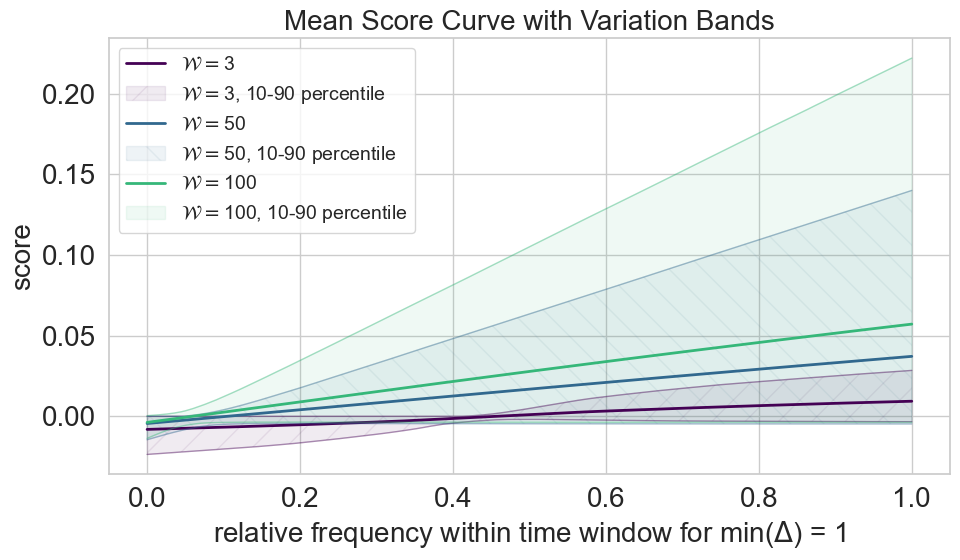

In [144]:
from turtle import color


hp_settings = df_all["hyperparam"].unique()
hp_settings = windows_plot
# x-values for plotting linear curves
x = np.linspace(0, 1, 200)
plt.figure(figsize=(10, 6))

plt.rcParams.update({
    'font.size': FONTSIZE+4,          # default text size
    'axes.titlesize': FONTSIZE+4,     # title
    'axes.labelsize': LABELSIZE+4,     # x/y labels
    'xtick.labelsize': LABELSIZE+4,    # x-tick labels
    'ytick.labelsize': LABELSIZE+4,    # y-tick labels
    'legend.fontsize': LABELSIZE-2    # legend
})
# color = plt.cm.viridis(i)
hatch_patterns = ['/', '\\',   '', '|', '-', '+', 'x', 'o', 'O', '.', '*']
for i, hp in enumerate(hp_settings):
    color = plt.cm.viridis(i / (len(hp_settings)))
    df_hp = df_all[df_all["hyperparam"] == hp]
    curves = np.array([
        score_linear(x, row.rho, row.kappa, row.gamma)
        for row in df_hp.itertuples()
    ])

    # Mean curve
    mean_curve = curves.mean(axis=0)

    # Percentile band
    # p10 = np.percentile(curves, 10, axis=0)
    # p90 = np.percentile(curves, 90, axis=0)

    # # Plot mean
    # plt.plot(x, mean_curve, label=f"{hp} mean", linewidth=2)

    # # Fill variability band
    # plt.fill_between(x, p10, p90, alpha=0.15)

    p10 = np.percentile(curves, 10, axis=0)
    p90 = np.percentile(curves, 90, axis=0)
    p25 = np.percentile(curves, 25, axis=0)
    p75 = np.percentile(curves, 75, axis=0)


    

    plt.plot(x, mean_curve, color=color, lw=2, label="$\mathcal{W}=$" + f"{hp}")
    plt.plot(x, p90, color=color, lw=1, alpha=0.4)
    plt.plot(x, p10, color=color, lw=1, alpha=0.4)
    plt.fill_between(x, p10, p90, alpha=0.08,  hatch=hatch_patterns[i], edgecolor=color, facecolor=color, label="$\mathcal{W}=$" + f"{hp}, 10-90 percentile")
    # plt.fill_between(x, p25, p75, alpha=0.08, edgecolor=color, facecolor=color)

plt.xlabel("relative frequency within time window for min($\Delta$) = 1")
plt.ylabel("score")
plt.title("Mean Score Curve with Variation Bands")
plt.legend()
plt.tight_layout()
plt.savefig(f"mean_score_curve_with_variation_bands_g_{dataset_name}.png")
plt.savefig(f"mean_score_curve_with_variation_bands_g_{dataset_name}.pdf")
plt.show()

In [145]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial

p = Polynomial.fit(x, mean_curve, deg=1)
fit_curve = p(x)

np.allclose(mean_curve, fit_curve)

False

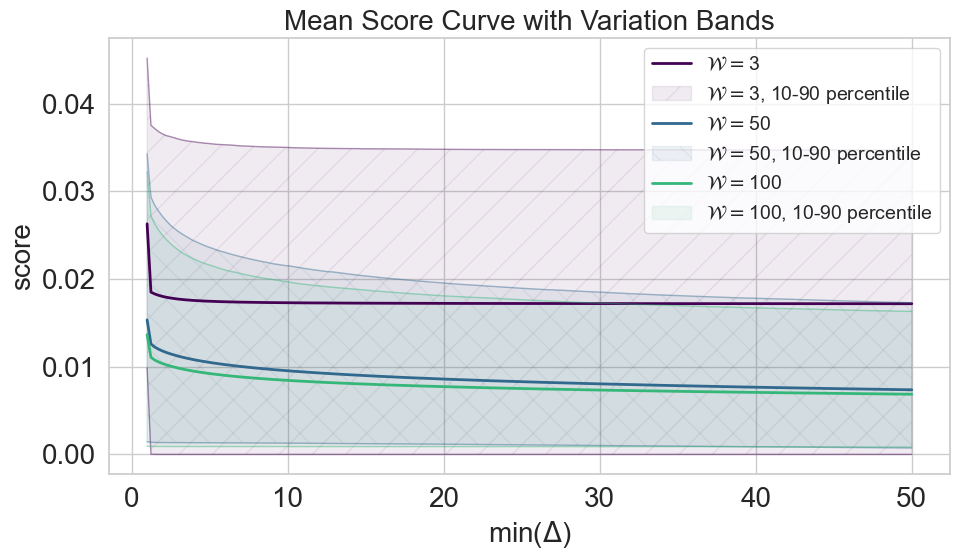

In [146]:

from turtle import color


hp_settings = df_all["hyperparam"].unique()
hp_settings = windows_plot
# x-values for plotting linear curves
x = np.linspace(1, 50, 200)

plt.figure(figsize=(10, 6))
plt.rcParams.update({
    'font.size': FONTSIZE+4,          # default text size
    'axes.titlesize': FONTSIZE+4,     # title
    'axes.labelsize': LABELSIZE+4,     # x/y labels
    'xtick.labelsize': LABELSIZE+4,    # x-tick labels
    'ytick.labelsize': LABELSIZE+4,    # y-tick labels
    'legend.fontsize': LABELSIZE-2    # legend
})
hatch_patterns = ['/', '\\',   '', '|', '-', '+', 'x', 'o', 'O', '.', '*']
# color = plt.cm.viridis(i)
for i, hp in enumerate(hp_settings):
    color = plt.cm.viridis(i / (len(hp_settings)))
    
    df_hp = df_all[df_all["hyperparam"] == hp]

    # Compute all curves for this HP setting
    curves = np.array([
        score_single(x, row.lmbda, row.alpha, row.phi)
        for row in df_hp.itertuples()
    ])

    # Mean curve
    mean_curve = curves.mean(axis=0)

    # Percentile band
    p10 = np.percentile(curves, 10, axis=0)
    p90 = np.percentile(curves, 90, axis=0)
    p25 = np.percentile(curves, 25, axis=0)
    p75 = np.percentile(curves, 75, axis=0)


    

    plt.plot(x, mean_curve, color=color, lw=2, label="$\mathcal{W}=$" + f"{hp}")
    plt.plot(x, p90, color=color, lw=1, alpha=0.4)
    plt.plot(x, p10, color=color, lw=1, alpha=0.4)
    # plt.fill_between(x, p10, p90, alpha=0.15, hatch='///', edgecolor=color, facecolor='none')
    plt.fill_between(x, p10, p90, alpha=0.08,  hatch=hatch_patterns[i], edgecolor=color, facecolor=color, label="$\mathcal{W}=$" + f"{hp}, 10-90 percentile")



plt.xlabel("min($\Delta$)")
plt.ylabel("score")
plt.title("Mean Score Curve with Variation Bands")
plt.legend()
plt.tight_layout()
plt.savefig(f"mean_score_curve_with_variation_bands_f_{dataset_name}.png")
plt.savefig(f"mean_score_curve_with_variation_bands_f_{dataset_name}.pdf")
plt.show()